In [1]:
# Allow memory growth for GPUs - Skip this cell if using CPU

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
'''
https://www.kaggle.com/dimakyn/keras-cnn-autoencoder
'''

'\nhttps://www.kaggle.com/dimakyn/keras-cnn-autoencoder\n'

In [3]:
#Import Libraries
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


#Set constants
IMG_W = 258
IMG_H = 540
BS = 20
EPOCHS = 100
AUTOENCODER_MODEL_FILENAME = 'document_denoising_autoencoder.hdf5'
STACKER_MODEL_FILENAME = 'document_denoising_stacker.hdf5'

[INFO] Image shape: (420, 540) 
[INFO] Image shape: (420, 540) 


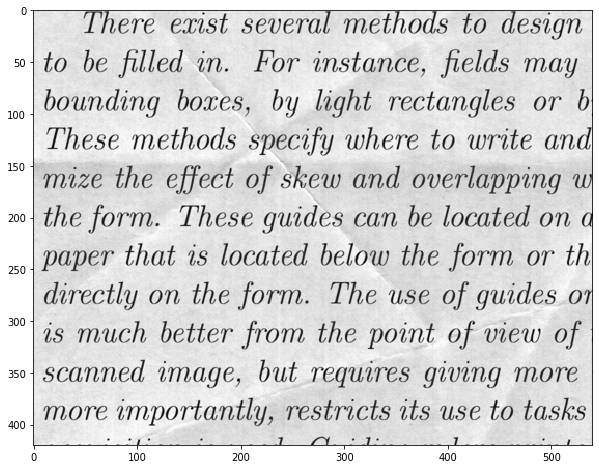

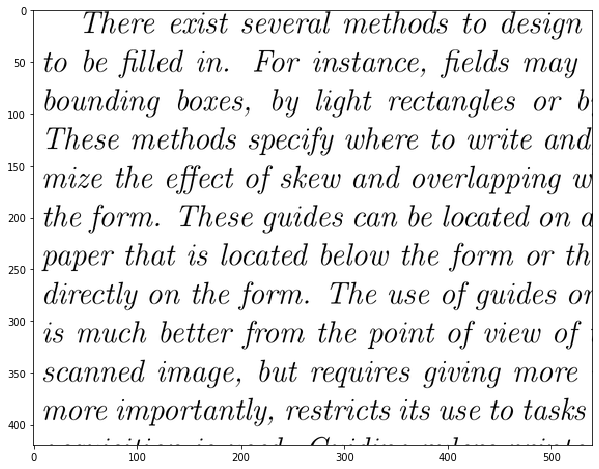

In [4]:
# Visualize a sample image from the training set

def im_show(im_name):
    plt.figure(figsize=(20,8))
    img = cv2.imread(im_name, 0)
    plt.imshow(img, cmap="gray")
    print(f"[INFO] Image shape: {img.shape} ")

im_show("datasets/train/77.png")
im_show("datasets/train_cleaned/77.png")

In [5]:
# Load datasets and print summary of data

TRAIN_IMAGES = glob.glob('datasets/train/*.png')
CLEAN_IMAGES = glob.glob('datasets/train_cleaned/*.png')
TEST_IMAGES = glob.glob('datasets/test/*.png')
print(f"[INFO] Number of train pictures: {len(TRAIN_IMAGES)}")
print(f"[INFO] Number of train_cleaned pictures: {len(CLEAN_IMAGES)}")
print(f"[INFO] Number of test pictures: {len(TEST_IMAGES)}")

[INFO] Number of train pictures: 144
[INFO] Number of train_cleaned pictures: 144
[INFO] Number of test pictures: 72


In [6]:
#Preprocess images and load into training and test sets

from image_loader import ImageLoader
im_loader = ImageLoader(IMG_W, IMG_H)

x_train = im_loader.load_image(TRAIN_IMAGES)
y_train = im_loader.load_image(CLEAN_IMAGES)
x_test = im_loader.load_image(TEST_IMAGES)

In [7]:
# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, 
                                                  random_state=42)

In [8]:
# Create deep convolutional autoencoder and view model summary

# Import custom model class from deep_conv_autoencoder.py
from deep_conv_autoencoder import AE

autoencoder = AE.create_model(IMG_W, IMG_H)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 258, 540, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________

In [9]:
# Define model callbacks

early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
checkpoint = ModelCheckpoint(AUTOENCODER_MODEL_FILENAME, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [10]:
# Train model and store training history

history = autoencoder.fit(x_train, y_train,
                         batch_size=BS,
                         epochs=EPOCHS,
                         validation_data=([x_val, x_val], y_val),
                         callbacks=[early_stopping, checkpoint]
                        )

Train on 122 samples, validate on 22 samples
Epoch 1/100
120/122 [============================>.] - ETA: 0s - loss: 0.1423
Epoch 00001: val_loss improved from inf to 0.07044, saving model to document_denoising_autoencoder.hdf5
122/122 [==============================] - 4s 33ms/sample - loss: 0.1412 - val_loss: 0.0704
Epoch 2/100
120/122 [============================>.] - ETA: 0s - loss: 0.0714
Epoch 00002: val_loss did not improve from 0.07044
122/122 [==============================] - 1s 8ms/sample - loss: 0.0717 - val_loss: 0.0772
Epoch 3/100
120/122 [============================>.] - ETA: 0s - loss: 0.0763WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

In [11]:
# Visualize training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

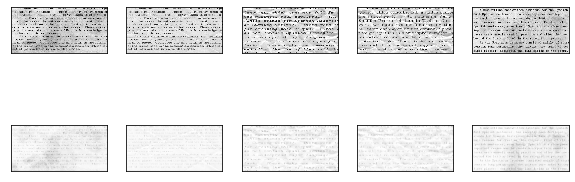

In [12]:
def plot_images(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()
    
# Demonstrate model performance on test data    
preds = autoencoder.predict(x_test)
plot_images(x_test[:5], preds[:5])

In [13]:
# Load pre-trained autoencoder model
autoencoder = load_model(AUTOENCODER_MODEL_FILENAME)

In [14]:
# Load and preprocess images using default images, opencv processing methods, and autoencoder

x_train = im_loader.load_image(TRAIN_IMAGES) + \
          im_loader.load_image_blur(TRAIN_IMAGES) + \
          im_loader.load_image_canny_dilate_erode(TRAIN_IMAGES) + \
          im_loader.load_image_threshold(TRAIN_IMAGES, 'binary') + \
          im_loader.load_image_threshold(TRAIN_IMAGES) + \
          im_loader.load_image_threshold(TRAIN_IMAGES, 'adaptive_mean') + \
          autoencoder.predict(im_loader.load_image(TRAIN_IMAGES))

x_test = im_loader.load_image(TEST_IMAGES) + \
          im_loader.load_image_blur(TEST_IMAGES) + \
          im_loader.load_image_canny_dilate_erode(TEST_IMAGES) + \
          im_loader.load_image_threshold(TEST_IMAGES, 'binary') + \
          im_loader.load_image_threshold(TEST_IMAGES) + \
          im_loader.load_image_threshold(TEST_IMAGES, 'adaptive_mean') + \
          autoencoder.predict(im_loader.load_image(TEST_IMAGES))          

y_train = im_loader.load_image(CLEAN_IMAGES)

In [15]:
# Split training data into training and validation sets

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [16]:
# Create stacked autoencoder model

stacker = AE.create_model(IMG_W, IMG_H)
stacker.compile(optimizer='adam', loss='mse')
stacker.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 258, 540, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_______________________________________________________

In [17]:
# Define model callbacks

early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
checkpoint = ModelCheckpoint(STACKER_MODEL_FILENAME, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [18]:
# Train model and store training history

history = autoencoder.fit(x_train, y_train,
                         batch_size=BS,
                         epochs=EPOCHS,
                         validation_data=(x_val, y_val),
                         callbacks=[early_stopping, checkpoint]
                        )

Train on 122 samples, validate on 22 samples
Epoch 1/100
120/122 [============================>.] - ETA: 0s - loss: 0.0832
Epoch 00001: val_loss improved from inf to 0.08492, saving model to document_denoising_stacker.hdf5
122/122 [==============================] - 1s 12ms/sample - loss: 0.0832 - val_loss: 0.0849
Epoch 2/100
120/122 [============================>.] - ETA: 0s - loss: 0.0830
Epoch 00002: val_loss did not improve from 0.08492
122/122 [==============================] - 1s 9ms/sample - loss: 0.0832 - val_loss: 0.0849
Epoch 3/100
120/122 [============================>.] - ETA: 0s - loss: 0.0832
Epoch 00003: val_loss did not improve from 0.08492
122/122 [==============================] - 1s 9ms/sample - loss: 0.0832 - val_loss: 0.0849
Epoch 4/100
120/122 [============================>.] - ETA: 0s - loss: 0.0830
Epoch 00004: val_loss did not improve from 0.08492
122/122 [==============================] - 1s 9ms/sample - loss: 0.0832 - val_loss: 0.0849
Epoch 5/100
120/122 [====

KeyboardInterrupt: 

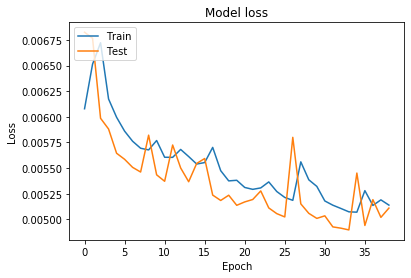

In [22]:
# Visualize training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

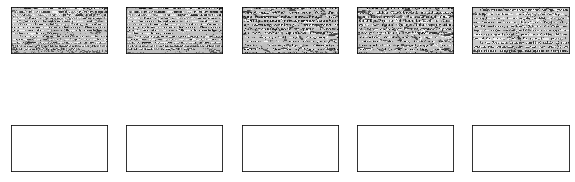

In [19]:
# Demonstrate model performance on test data    
stacker = load_model(STACKER_MODEL_FILENAME)
preds = stacker.predict(x_test)
plot_images(x_test[:5], preds[:5])